<a href="https://colab.research.google.com/github/lk2521/image-caption-generator/blob/main/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Caption Generator using Deep Learning

### Dataset used for Image Caption Generator:
* [Flicker_8k Dataset](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip)
* [Flickr_8k_text](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip)


* In the Flickr_8k_text folder,  the most important file is Flickr 8k.token, which stores all the image names with captions.
* 8091 images are stored inside the Flicker8k_Dataset folder and the text files with captions of images are stored in the Flickr_8k_text folder.

## Install and Import Required Packages

In [9]:
# Install below packages if not already done
# !pip install tensorflow keras pillow numpy tqdm

In [10]:
import os
import string
import numpy as np
import tensorflow as tf
from pickle import dump
from pickle import load
from PIL import Image
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.utils import load_img
from keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense #Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm.notebook import tqdm #to check loop progress
tqdm().pandas()

0it [00:00, ?it/s]

## Getting and Performing Data Cleaning

In [11]:
# Load the document file into memory
def load_doc(filename):
    # Open file to read
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Get all images with their captions
def img_capt(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions


# Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            descp = img_caption.split()
            #uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            #remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            #remove hanging 's and a
            descp = [wrd for wrd in descp if(len(wrd)>1)]
            #remove words containing numbers with them
            descp = [wrd for wrd in descp if(wrd.isalpha())]
            #converting back to string
            img_caption = ' '.join(descp)
            captions[img][i]= img_caption
    return captions


def txt_vocab(descriptions):
    # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab


# To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [12]:
# Creating the directories for storing data
os.makedirs('data_dir/image')
os.makedirs('data_dir/text')

### Loading the Dataset from Github Source

In [13]:
# image dataset files
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip &>/dev/null
!unzip Flickr8k_Dataset.zip -d data_dir/image &>/dev/null

# text dataset files
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip &>/dev/null
!unzip Flickr8k_text.zip -d data_dir/text &>/dev/null

In [14]:
dataset_text = "data_dir/text"
dataset_images = "data_dir/image/Flicker8k_Dataset"

# to prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"

# loading the file that contains all data
# map them into descriptions dictionary img to 5 captions
descriptions = img_capt(filename)
print("Length of descriptions = " ,len(descriptions))

# cleaning the descriptions
clean_descriptions = txt_clean(descriptions)

# to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving all descriptions in one file
save_descriptions(clean_descriptions, "data_dir/descriptions.txt")

Length of descriptions =  8092
Length of vocabulary =  8763


## Extracting the Feature Vectors from Images

In [15]:
def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for pic in tqdm(os.listdir(directory)):
        file = directory + "/" + pic
        image = Image.open(file)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        #image = preprocess_input(image)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        features[pic] = feature
    return features

In [ ]:
# 2048 feature vectors
features = extract_features(dataset_images)
dump(features, open("data_dir/features.p","wb"))

# to directly load the features from the pickle file.
features = load(open("data_dir/features.p","rb"))

## Loading Dataset for Training the Model

In [17]:
#load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1:
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = ' ' + " ".join(image_caption) + ' '
            descriptions[image].append(desc)
    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("data_dir/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("data_dir/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [18]:
len(train_descriptions)

6000

## Tokenizing the Vocabulary

In [19]:
#convert dictionary to clear list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocab Size =', vocab_size)

#calculate maximum length of descriptions to decide the model structure parameters.
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
print('Max Length =', max_length)

Vocab Size = 7577
Max Length = 32


## Creating Data Generator

In [20]:
# create input-output sequence pairs from the image description

# data generator, used by model.fit()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[inp_image, inp_seq], op_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # divide one sequence into various X,y pairs
        for i in range(1, len(seq)):
            # divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)

#To check the shape of the input and output for your model

[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

#((47, 2048), (47, 32), (47, 7577))

((37, 2048), (37, 32), (37, 7577))

## Defining the CNN-LSTM Model

In [21]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Training the Model

In [22]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1939712     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']    

In [23]:
# creating a directory named models to save our models
os.makedirs("data_dir/models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

6000/6000 [==============================] - 1606s 268ms/step - loss: 2.9070


## Testing the Model

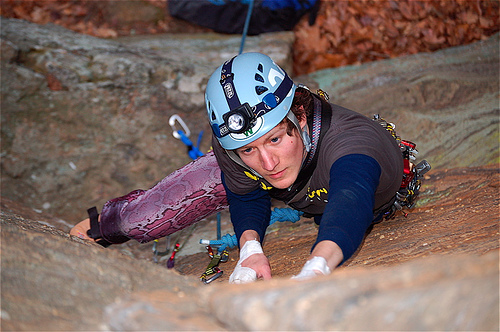

In [26]:
from PIL import Image
img = Image.open('data_dir/image/Flicker8k_Dataset/111537222_07e56d5a30.jpg')
img

In [29]:
import matplotlib.pyplot as plt

def extract_features(filename, model):
    try:
        image = Image.open(filename)

    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
    # for images that has 4 channels, we convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [48]:
path = 'data_dir/image/Flicker8k_Dataset/'
test_image_list = ['1057089366_ca83da0877.jpg',
                   '3150315970_8f045c41a4.jpg',
                   '3154528397_89112faf4b.jpg',
                   '3167365436_c379bda282.jpg',
                   '3523471597_87e0bf3b21.jpg',
                   '979201222_75b6456d34.jpg',
                   '441921713_1cafc7d7d2.jpg',
                   '111537222_07e56d5a30.jpg']

In [36]:
test_image_list[0]

'1057089366_ca83da0877.jpg'

In [37]:
def test_caption(img_path, model, tokenizer, max_length):
    xception_model = Xception(include_top=False, pooling="avg")
    photo = extract_features(img_path, xception_model)
    img = Image.open(img_path)
    description = generate_desc(model, tokenizer, photo, max_length)
    print("\n\n")
    print(description)
    plt.imshow(img)

max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')

In [49]:
img_path = []
for img in test_image_list:
    img_path.append(path + img)

1/1 [==============================] - 2s 2s/step



start of three people are standing in the water and one is standing in the water and smiles for the camera while another child watches from the frog cleaning the seeds of the


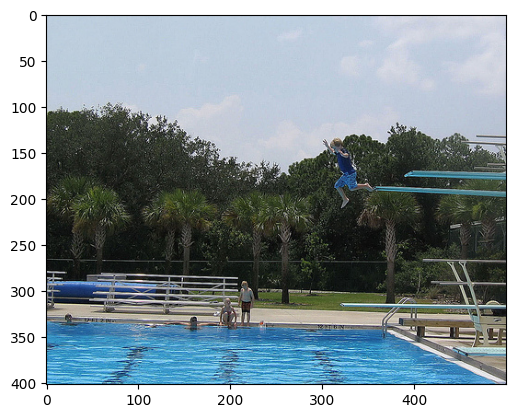

In [50]:
test_caption(img_path[0], model, tokenizer, max_length)

1/1 [==============================] - 2s 2s/step



start of people are standing in front of building with water in the background in front of them with water in the background in the background in the background in the background in


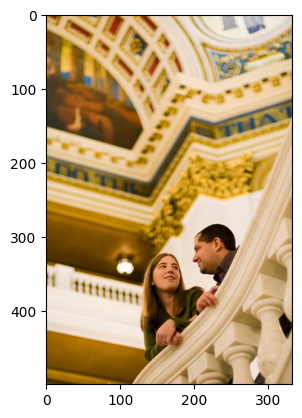

In [41]:
test_caption(img_path[1], model, tokenizer, max_length)

1/1 [==============================] - 3s 3s/step



start biker is airborne in the snow with trees in the background on behind him in the background on the ground and ice sculpture machines in the background wearing red helmet is riding


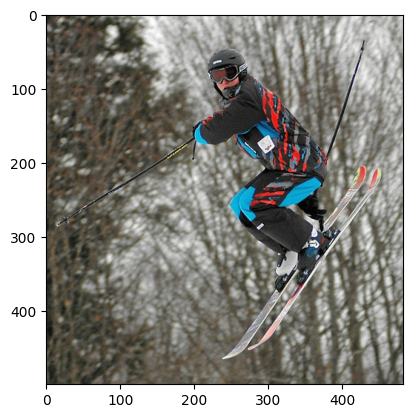

In [43]:
test_caption(img_path[2], model, tokenizer, max_length)

1/1 [==============================] - 2s 2s/step



start man in black shirt is standing next to man in black shirt and black hat with long hair in front of building with water in the background in the background in the


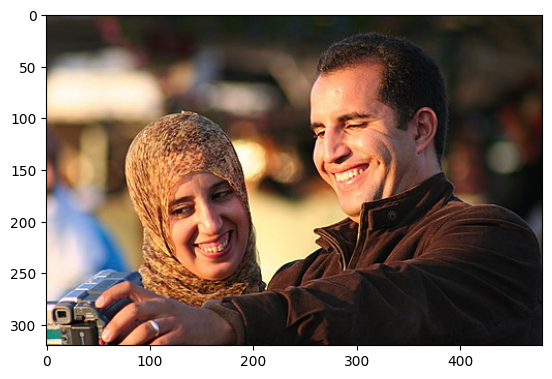

In [44]:
test_caption(img_path[3], model, tokenizer, max_length)

1/1 [==============================] - 1s 1s/step



start man in white shirt is sitting on bench with his arms in the background hand is sitting on the sidewalk with his arms around his arm on the street in front of


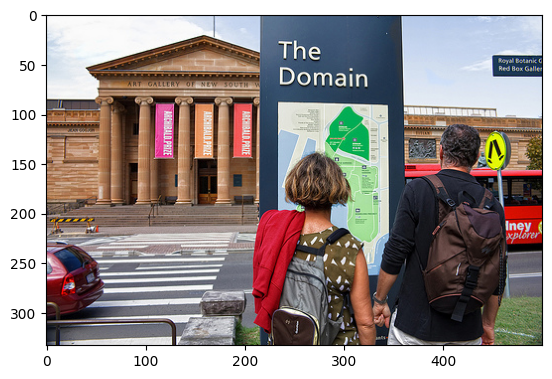

In [45]:
test_caption(img_path[4], model, tokenizer, max_length)

1/1 [==============================] - 1s 1s/step



start man in white shirt is standing in front of building with traffic shop in front of him and cars stop by her walking in the background in front of them and buildings


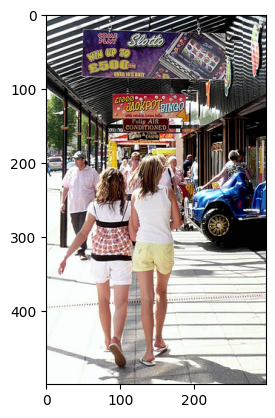

In [46]:
test_caption(img_path[5], model, tokenizer, max_length)

1/1 [==============================] - 1s 1s/step



start man is standing in front of building with two people in the background in front of them with long hair and red shirt and black shirt and black shirt and black pants


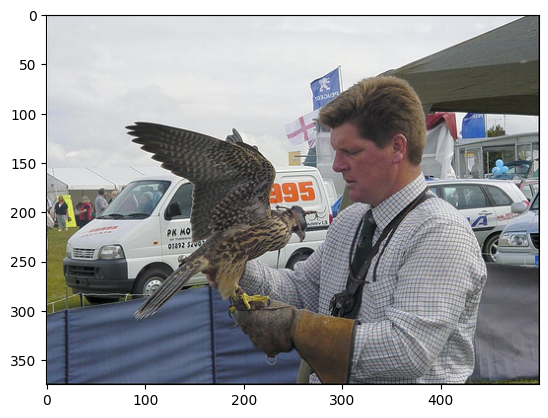

In [47]:
test_caption(img_path[6], model, tokenizer, max_length)

1/1 [==============================] - 2s 2s/step



start mountain climber is climbing up rock face in the background below him in the background in front of them is sitting on the ground with red safety shirt on his waist and


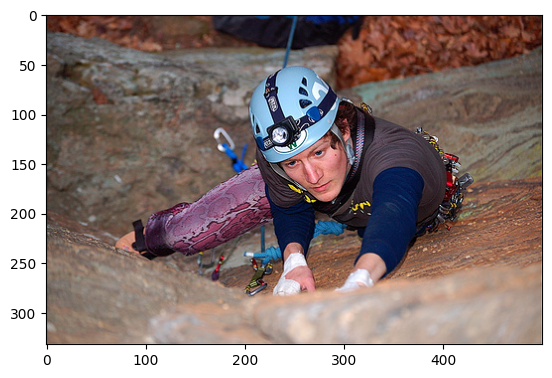

In [51]:
test_caption(img_path[7], model, tokenizer, max_length)